Base dir: C:\Users\rebec\OneDrive\Documents\Machine Learning\Team Project
Data path: C:\Users\rebec\OneDrive\Documents\Machine Learning\Team Project\public_cases.csv
Model dir: C:\Users\rebec\OneDrive\Documents\Machine Learning\Team Project\models
Model files: ['decision_tree.pkl', 'ensemble_weights.json', 'feature_names.json', 'gradient_boosting.pkl', 'lasso.pkl', 'linear_regression.pkl', 'neural_network.pkl', 'nn_scaler.pkl', 'random_forest.pkl', 'ridge.pkl']
Loading data...
Engineering features...
Splitting data (test_size=0.25)...
Training set: 750 samples
Test set: 250 samples
X_train shape: (750, 6)
X_test shape: (250, 6)

Loaded models: dict_keys(['decision_tree', 'gradient_boosting', 'lasso', 'linear_regression', 'neural_network', 'random_forest', 'ridge'])
Ensemble weights: {'linear_regression': 0.132913941252127, 'ridge': 0.13291418831199497, 'lasso': 0.13291785333466313, 'decision_tree': 0.14235044819880138, 'random_forest': 0.15402446898864117, 'gradient_boosting': 0.153405

,model,r2,mae,rmse
5,random_forest,0.940730,73.127392,111.312492
1,gradient_boosting,0.936948,75.779727,114.808833
4,neural_network,0.925152,90.102528,125.088668
0,decision_tree,0.869429,108.806898,165.215170
2,lasso,0.811818,161.559961,198.342492
6,ridge,0.811795,161.562733,198.354289
3,linear_regression,0.811794,161.563009,198.355084



=== Ensemble Performance ===
R²   : 0.9229
MAE  : $94.82
RMSE : $126.99


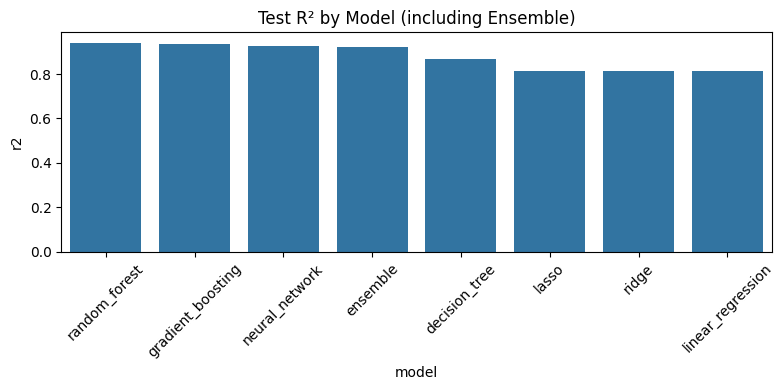

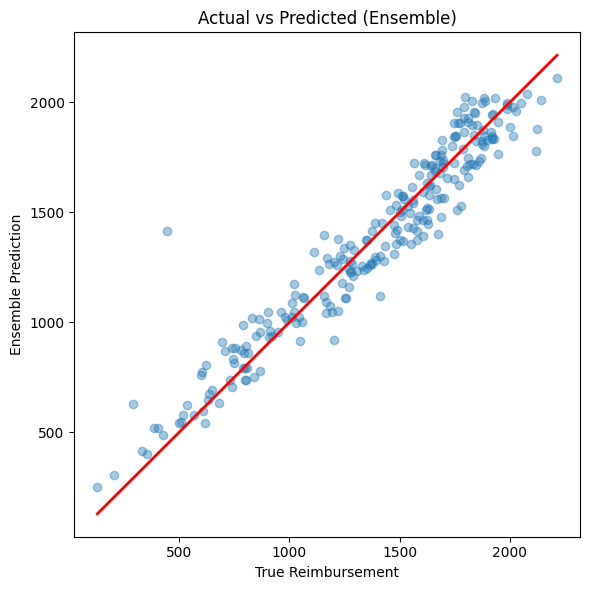

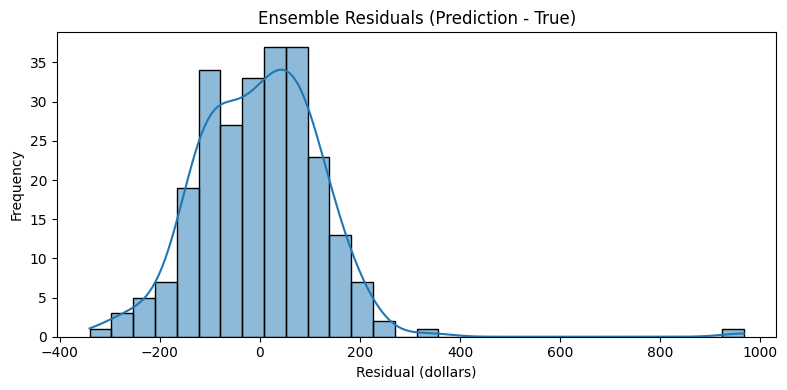

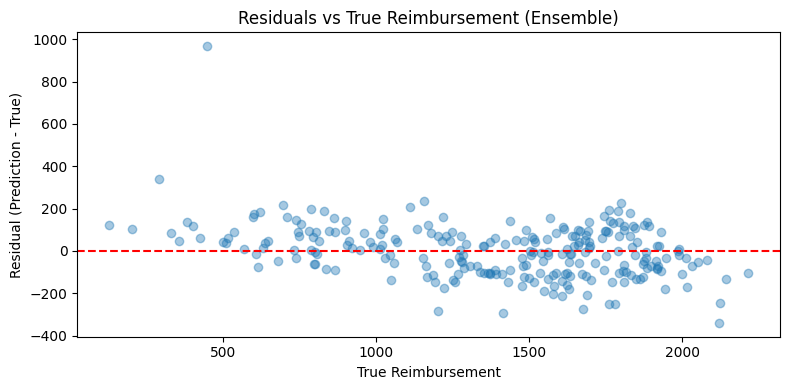

In [ ]:
import os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from train_models import ModelTrainer  # using existing training code

BASE_DIR = r"C:\Users\rebec\OneDrive\Documents\Machine Learning\Team Project"
DATA_PATH = os.path.join(BASE_DIR, "public_cases.csv")
MODEL_DIR = os.path.join(BASE_DIR, "models")

print("Base dir:", BASE_DIR)
print("Data path:", DATA_PATH)
print("Model dir:", MODEL_DIR)
print("Model files:", os.listdir(MODEL_DIR))


# Load data and recreate the train/test split
trainer = ModelTrainer(
    data_path=DATA_PATH,
    test_size=0.25,
    random_state=42
)

X_train, X_test, y_train, y_test = trainer.load_and_prepare_data()

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


# Load trained models, NN scaler, and ensemble weights
models = {}

for fname in os.listdir(MODEL_DIR):
    if fname.endswith(".pkl") and fname != "nn_scaler.pkl":
        name = fname.replace(".pkl", "")
        with open(os.path.join(MODEL_DIR, fname), "rb") as f:
            models[name] = pickle.load(f)

# Load neural network scaler
with open(os.path.join(MODEL_DIR, "nn_scaler.pkl"), "rb") as f:
    nn_scaler = pickle.load(f)

# Load ensemble weights
with open(os.path.join(MODEL_DIR, "ensemble_weights.json"), "r") as f:
    ensemble_weights = json.load(f)

# Load feature names (if needed)
with open(os.path.join(MODEL_DIR, "feature_names.json"), "r") as f:
    feature_names = json.load(f)

print("\nLoaded models:", models.keys())
print("Ensemble weights:", ensemble_weights)

# Evaluate individual models on the test set
results = []

for name, model in models.items():
    # Scaled features ONLY for the neural network
    if name == "neural_network":
        X_test_input = nn_scaler.transform(X_test)
    else:
        X_test_input = X_test

    y_pred = model.predict(X_test_input)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({
        "model": name,
        "r2": r2,
        "mae": mae,
        "rmse": rmse
    })

results_df = pd.DataFrame(results).sort_values("r2", ascending=False)
display(results_df)


# Build corrected ensemble predictions (NN uses scaled features, others raw)
ensemble_pred = np.zeros(len(X_test))

for name, weight in ensemble_weights.items():
    model = models[name]

    if name == "neural_network":
        preds = model.predict(nn_scaler.transform(X_test))
    else:
        preds = model.predict(X_test)

    ensemble_pred += weight * preds

# Compute ensemble metrics
ensemble_r2 = r2_score(y_test, ensemble_pred)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))

print("\n=== Ensemble Performance ===")
print(f"R²   : {ensemble_r2:.4f}")
print(f"MAE  : ${ensemble_mae:.2f}")
print(f"RMSE : ${ensemble_rmse:.2f}")

# Add ensemble to the results table for plotting
results_plus_ensemble = results_df.copy()
results_plus_ensemble = pd.concat(
    [
        results_plus_ensemble,
        pd.DataFrame([{
            "model": "ensemble",
            "r2": ensemble_r2,
            "mae": ensemble_mae,
            "rmse": ensemble_rmse
        }])
    ],
    ignore_index=True
)

# Visualization: R² by model (including ensemble)
plt.figure(figsize=(8, 4))
sns.barplot(data=results_plus_ensemble.sort_values("r2", ascending=False),
            x="model", y="r2")
plt.title("Test R² by Model (including Ensemble)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualization: Actual vs Predicted (Ensemble)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, ensemble_pred, alpha=0.4)
plt.xlabel("True Reimbursement")
plt.ylabel("Ensemble Prediction")
plt.title("Actual vs Predicted (Ensemble)")

# Perfect-prediction reference line
min_val = min(y_test.min(), ensemble_pred.min())
max_val = max(y_test.max(), ensemble_pred.max())
plt.plot([min_val, max_val], [min_val, max_val],
         color="red", linewidth=2)

plt.tight_layout()
plt.show()

# Visualization: Ensemble residuals histogram
residuals = ensemble_pred - y_test

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Ensemble Residuals (Prediction - True)")
plt.xlabel("Residual (dollars)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Visualization: Residuals vs True (to spot patterns)
plt.figure(figsize=(8, 4))
plt.scatter(y_test, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True Reimbursement")
plt.ylabel("Residual (Prediction - True)")
plt.title("Residuals vs True Reimbursement (Ensemble)")
plt.tight_layout()
plt.show()


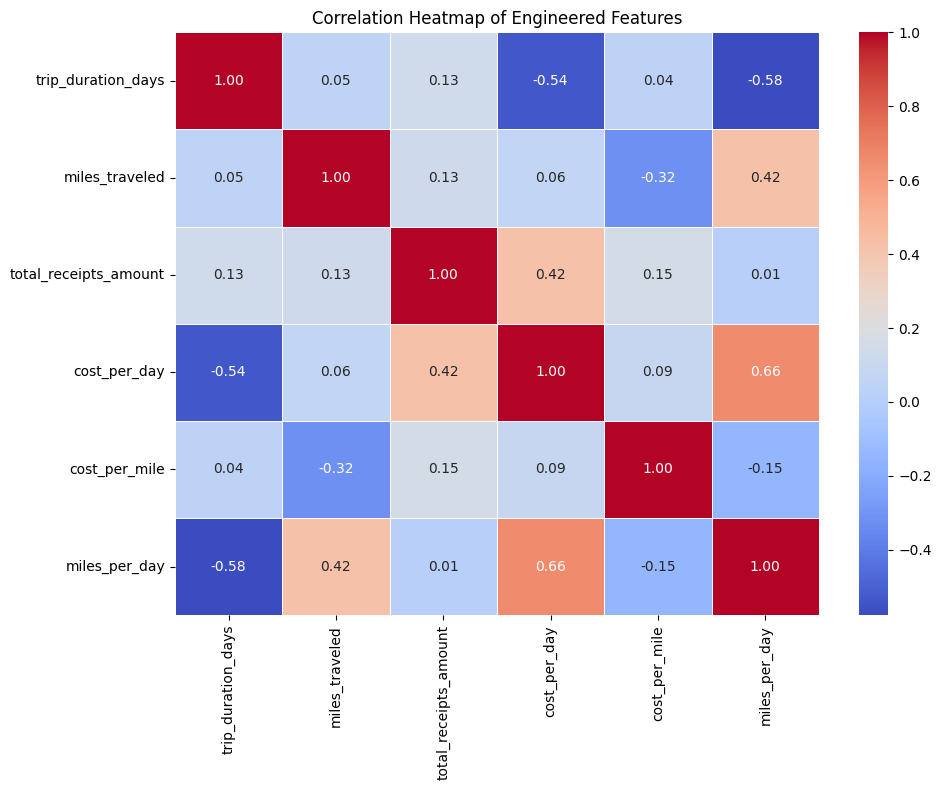

In [6]:
# Combine train and test for a full correlation view
X_full = pd.concat([X_train, X_test], axis=0)

plt.figure(figsize=(10, 8))
sns.heatmap(
    X_full.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap of Engineered Features")
plt.tight_layout()
plt.show()


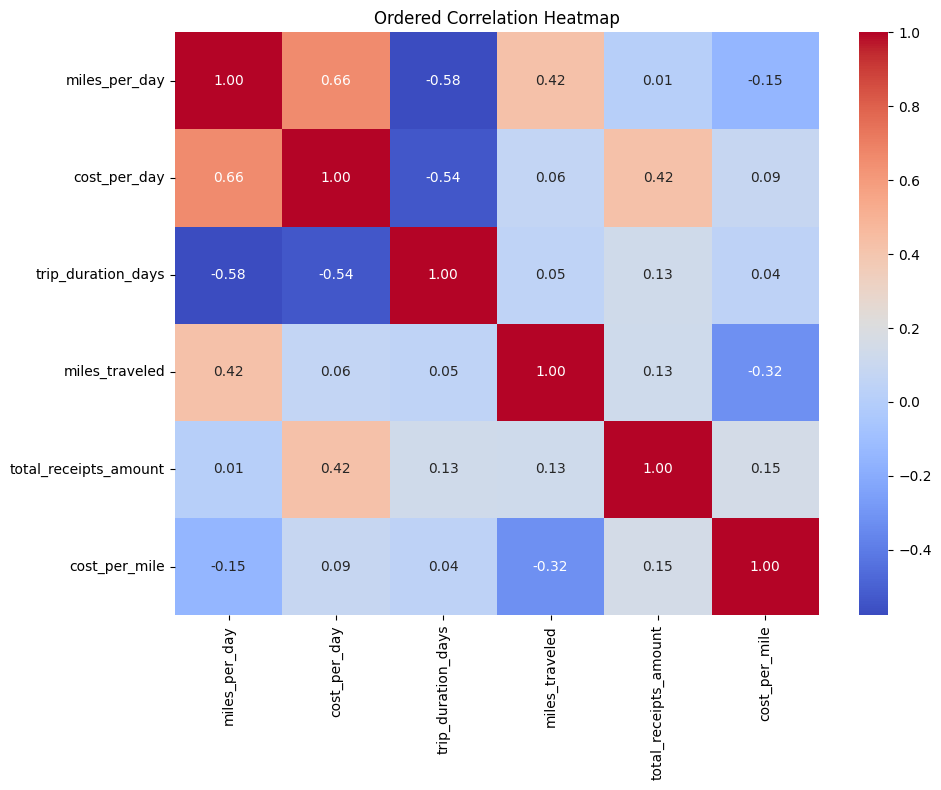

In [7]:
corr = X_full.corr()
ordered_cols = corr.abs().mean().sort_values(ascending=False).index

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr.loc[ordered_cols, ordered_cols],
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Ordered Correlation Heatmap")
plt.tight_layout()
plt.show()


C:\Users\rebec\AppData\Local\Temp\ipykernel_37580\45851244.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_df, x="importance", y="feature", palette="Blues_r")


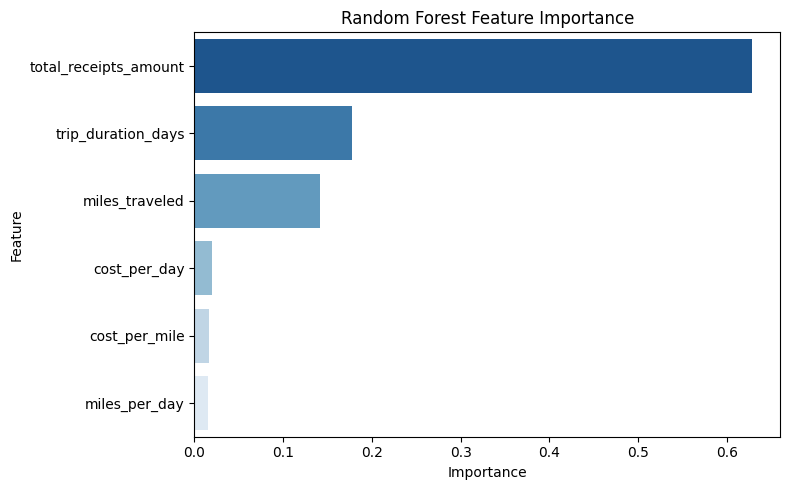

C:\Users\rebec\AppData\Local\Temp\ipykernel_37580\45851244.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gb_df, x="importance", y="feature", palette="Greens_r")


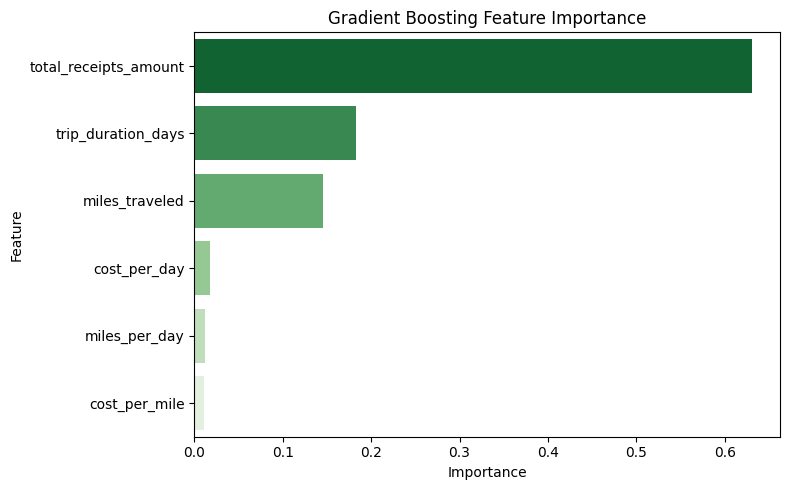

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ------------------------------------------
# 1. Get feature names
# ------------------------------------------
feature_names = X_train.columns

# ------------------------------------------
# 2. Random Forest feature importances
# ------------------------------------------
rf_model = models["random_forest"]
rf_importances = rf_model.feature_importances_

rf_df = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=rf_df, x="importance", y="feature", palette="Blues_r")
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# ------------------------------------------
# 3. Gradient Boosting feature importances
# ------------------------------------------
gb_model = models["gradient_boosting"]
gb_importances = gb_model.feature_importances_

gb_df = pd.DataFrame({
    "feature": feature_names,
    "importance": gb_importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=gb_df, x="importance", y="feature", palette="Greens_r")
plt.title("Gradient Boosting Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
